In [2]:
import pandas as pd
import numpy as np
import pygad
import random
import copy

In [3]:
import csv

# Initialize an empty dictionary
enginge_RUL = {}

with open('RUL_consultancy_predictions_A3-2.csv', newline='') as csvfile:
    # Create a CSV reader object with semicolon as delimiter
    reader = csv.reader(csvfile, delimiter=';')
    # Skip the header row
    next(reader)
    # Loop over each row in the CSV
    for row in reader:
        # Check if row has exactly 2 columns
        if len(row) == 2:
            enginge_RUL[int(row[1])] = int(row[0])

In [4]:
engine_RUL_30 = {key: value for key, value in enginge_RUL.items() if value <= 30}

In [5]:
Team_A_time = {key: 4 for key in range(1, 21)}
Team_A_time.update({key: 3 for key in range(21, 56)})
Team_A_time.update({key: 2 for key in range(56, 81)})
Team_A_time.update({key: 8 for key in range(81, 101)})

Team_B_time = {j : Team_A_time[j] + 1 for j in range(1, 26)}
Team_B_time.update({j : Team_A_time[j] + 2 for j in range(26, 71)})
Team_B_time.update({j : Team_A_time[j] + 1 for j in range(71, 101)})

In [6]:
T1_time = Team_A_time
T2_time = Team_B_time
T3_time = Team_A_time
T4_time = Team_B_time

# Random Initializer

In [7]:
def calculate_team_work_time(team, engines):
    if team in ["T1", "T3"]:
        engine_times = Team_A_time
    else:
        engine_times = Team_B_time
    
    time = 0
    
    for engine in engines:
        time += engine_times[engine]
    
    return time
    

def random_init(engines_RUL):
    schedule = {"T1":[], "T2":[], "T3":[], "T4":[]}
    
    possible_engines = list(engines_RUL.keys())
    possible_teams = ["T1", "T2", "T3", "T4"]
    
    iterations = 0 
    
    while possible_engines and iterations < 500:
        index = random.randrange(4)
        team = possible_teams[index]
        
        index = random.randrange(len(possible_engines))
        selected_engine = possible_engines[index]
        
        schedule[team].append(selected_engine)
        
        possible_engines.remove(selected_engine)
        
        iterations += 1

    return schedule

In [8]:
random_init(engine_RUL_30)

{'T1': [61, 90, 40, 56, 91],
 'T2': [41, 76, 36, 20, 82, 77, 81],
 'T3': [31, 66, 42],
 'T4': [92, 34, 24, 35, 64, 37, 100, 49, 68]}

# Loss Function

In [9]:
def engine_fix_date(schedule):
    engine_fix = {}
    for team in schedule:
        days = 0
        if team == "T1" or team == "T3":
            time_table = Team_A_time
        else:
            time_table = Team_B_time
            
        for engine in schedule[team]:
            engine_fix[engine] = days
            days = days + time_table[engine]
              
    return engine_fix


initial_schedule = random_init(engine_RUL_30)
print(initial_schedule)

engine_cost = {key: 4 for key in range(1, 21)}
engine_cost.update({key: 3 for key in range(21, 31)})
engine_cost.update({key: 2 for key in range(31, 46)})
engine_cost.update({key: 5 for key in range(46, 81)})
engine_cost.update({key: 6 for key in range(81, 100)})


def loss_function(schedule, engine_RUL, engine_cost):
    loss = 0
    fix_dates = engine_fix_date(schedule)
    print(fix_dates)
    print(engine_RUL)
    for team in schedule:
        for engine in schedule[team]:

            days_late = fix_dates[engine] - engine_RUL[engine]
            engine_loss = 0
            if days_late > 0:
                cost = engine_cost[engine]
    
                for i in range(days_late):
                    day_loss = cost * (i ** 2)
                    if day_loss > 250:
                        day_loss = 250
                    engine_loss += day_loss
            loss += engine_loss
        
    return loss  

loss_schedule = loss_function(initial_schedule, engine_RUL_30, engine_cost)
print(loss_schedule)

{'T1': [90, 68, 91, 36], 'T2': [40, 100, 66, 82, 42, 81], 'T3': [34, 77, 76, 64, 24, 92, 49, 37], 'T4': [41, 35, 56, 31, 61, 20]}
{90: 0, 68: 8, 91: 10, 36: 18, 40: 0, 100: 5, 66: 14, 82: 18, 42: 27, 81: 32, 34: 0, 77: 3, 76: 5, 64: 7, 24: 9, 92: 12, 49: 20, 37: 23, 41: 0, 35: 5, 56: 10, 31: 14, 61: 19, 20: 23}
{20: 10, 24: 26, 31: 14, 34: 8, 35: 8, 36: 24, 37: 21, 40: 29, 41: 23, 42: 13, 49: 14, 56: 18, 61: 23, 64: 24, 66: 18, 68: 13, 76: 3, 77: 27, 81: 6, 82: 11, 90: 28, 91: 29, 92: 24, 100: 24}
9446


# Termination Criterion

In [10]:
# TO DO LATER

# Selection of parents

In [11]:
# TO DO SELECT ONE DROM PYGAD UTILS
# https://pygad.readthedocs.io/en/latest/pygad.html#parent-selection-methods

# Crossover

In [12]:
parent_1 = random_init(engine_RUL_30)
parent_2 = random_init(engine_RUL_30)

In [13]:
# maybe TO DO: ONLY DELETE THE ORIGINAL DUPLICATES, NOT THE SWAPPED DUPLICATES

def double_fixer(child, parent):
    doubles = []
    skipped_ones = []
    numbers = {}
    
    for team in parent:
        for engine in parent[team]:
            numbers[engine] = [0]
    
    for team in child:
        index = -1
        for engine in child[team]:
            index = index + 1
            numbers[engine][0] = numbers[engine][0] + 1
            numbers[engine].append(team)
            numbers[engine].append(index)
                
    for key in numbers:
        if numbers[key][0] == 0:
            skipped_ones.append(key)
        elif numbers[key][0] > 1:
            doubles.append(key)
    
    for fault in doubles:
        team = numbers[fault][-2]
        index = numbers[fault][-1]        
        next_missed_one = skipped_ones.pop()
        child[team][index] = next_missed_one
        
    return child

def find_center(parent, team, middle_down_round):
    if len(parent[team]) % 2 == 0:
            middle_index = len(parent[team]) // 2
            next_middle_down_round = middle_down_round
    else:
        if middle_down_round:
            middle_index = len(parent[team]) // 2             
            next_middle_down_round = False
        else: 
            middle_index = (len(parent[team]) // 2) + 1
            next_middle_down_round = True
    
    return middle_index, next_middle_down_round


In [14]:
def crossover(parent_1, parent_2):
    #parent_1 = parents[0]
    #parent_2 = parents[1]
    
    child1 = {key: [] for key in parent_1}
    child2 = {key: [] for key in parent_2} 
    cross_side = random.choice(["Left", "Right"]) # Right means you keep the right side of p1 and switch the right side of p2
       
    p1_middle_down_round = True
    p2_middle_down_round = True
    
    for team in parent_1:
        
        p1_middle, p1_middle_down_round = find_center(parent_1, team, p1_middle_down_round)
        p2_middle, p2_middle_down_round = find_center(parent_2, team, p2_middle_down_round)

        
        if cross_side == "Left":
            sub_schedule_p1 = parent_1[team][:p1_middle]
            sub_schedule_p2 = parent_2[team][:p2_middle]
            
            child1[team].extend(sub_schedule_p2)
            child1[team].extend(parent_1[team][p1_middle:])
            
            child2[team].extend(sub_schedule_p1)
            child2[team].extend(parent_2[team][p2_middle:])
        
        if cross_side == "Right":
            sub_schedule_p1 = parent_1[team][p1_middle:]
            sub_schedule_p2 = parent_2[team][p2_middle:]
            
            child1[team].extend(parent_1[team][:p1_middle])
            child1[team].extend(sub_schedule_p2)
            
            child2[team].extend(parent_2[team][:p2_middle])
            child2[team].extend(sub_schedule_p1)
    
    
    child1 = double_fixer(child1, parent_1)
    child2 = double_fixer(child2, parent_2)
    
    return child1, child2


In [15]:
def print_parent_formatted(parent, name):
    formatted = ',\n  '.join(f"'{key}': {value}" for key, value in parent.items())
    print(f"{name} = {{\n  {formatted}\n}}")

In [16]:


print_parent_formatted(parent_1, "parent_1")
print_parent_formatted(parent_2, "parent_2")

child1, child2 = crossover(parent_1, parent_2)

print_parent_formatted(child1, "child1: ")
print_parent_formatted(child2, "child2: ")
print(sum(len(value) for value in child1.values()))
print(sum(len(value) for value in child2.values()))


parent_1 = {
  'T1': [42, 49, 24, 36, 34, 61, 91, 92, 81],
  'T2': [66, 77, 37],
  'T3': [41, 64, 100, 68, 56],
  'T4': [90, 20, 76, 82, 31, 40, 35]
}
parent_2 = {
  'T1': [35, 40, 66, 56, 76],
  'T2': [91, 36, 42, 64, 41, 49, 81, 100],
  'T3': [37, 92, 68, 31],
  'T4': [34, 20, 61, 90, 82, 24, 77]
}
child1:  = {
  'T1': [35, 40, 34, 61, 91, 92, 81],
  'T2': [41, 36, 42, 64, 37],
  'T3': [66, 77, 100, 68, 56],
  'T4': [82, 20, 76, 90, 31, 24, 49]
}
child2:  = {
  'T1': [42, 49, 24, 36, 66, 56, 76],
  'T2': [61, 77, 41, 37, 81, 100],
  'T3': [92, 64, 68, 31],
  'T4': [90, 20, 34, 82, 91, 40, 35]
}
24
24


In [17]:
test = {}
test.update({1 : 0})
test.update({2 : 0})
print(test[1]) 
test[1] = 4
test[1] = test[1] + 1
print(test)

0
{1: 5, 2: 0}


# Mutation

In [18]:
# This function chooses a random engine in the schema, and returns its index and the team it is in now
def random_chooser(child):
    total_length = 0
    team_lengths = {}
    for team in child:
        length = len(child[team])
        team_lengths[team] = length
        total_length = total_length + length
    
    index = random.randrange(total_length)
    for team in team_lengths:
        if index - team_lengths[team] >= 0:
            index = index - team_lengths[team]
        else:
            index_team = team
            break
            
    return [index, index_team]

In [19]:
# we kunnen swaps doen als mutaties
def swap_mutation(child):
    engine1  = random_chooser(child)
    engine2 = random_chooser(child)
    print(engine1)
    print(engine2)
    
    new_child = copy.deepcopy(child)
    
    new_child[engine1[1]][engine1[0]] = child[engine2[1]][engine2[0]]
    new_child[engine2[1]][engine2[0]] = child[engine1[1]][engine1[0]]
    
    return new_child

In [20]:
print(child1)
new_swap_child = swap_mutation(child1)
print(new_swap_child)

{'T1': [35, 40, 34, 61, 91, 92, 81], 'T2': [41, 36, 42, 64, 37], 'T3': [66, 77, 100, 68, 56], 'T4': [82, 20, 76, 90, 31, 24, 49]}
[3, 'T3']
[4, 'T2']
{'T1': [35, 40, 34, 61, 91, 92, 81], 'T2': [41, 36, 42, 64, 68], 'T3': [66, 77, 100, 37, 56], 'T4': [82, 20, 76, 90, 31, 24, 49]}


In [21]:
# alleen mis is het beter om additie te doen ipv swap, anders worden je teams nooit meer langer na eerste paar generaties, aangezien ik denk dat alles redleijk snel uit averaged, 
# en terwijl je dit soort variaties mis wel wil?

def additive_mutation(child):
    possible_teams = ["T1", "T2", "T3", "T4"]
    to_remove = random_chooser(child)
    child_copy = copy.deepcopy(child)
    
    engine = child_copy[to_remove[1]].pop(to_remove[0])
    team_index = random.randrange(4)
    team = possible_teams[team_index]
    length_team = len(child_copy[team])
    index = random.randrange(length_team)
    
    child_copy[team].insert(index, engine)
    return child_copy


In [22]:
print(child1)
new_additive_child = additive_mutation(child1)
print(new_additive_child)

{'T1': [35, 40, 34, 61, 91, 92, 81], 'T2': [41, 36, 42, 64, 37], 'T3': [66, 77, 100, 68, 56], 'T4': [82, 20, 76, 90, 31, 24, 49]}
{'T1': [35, 40, 34, 61, 91, 92, 81], 'T2': [41, 36, 42, 37], 'T3': [66, 77, 100, 68, 56], 'T4': [82, 20, 76, 64, 90, 31, 24, 49]}


# Genetic Algorithm

In [23]:
def selection_func(population):
    selected_parents = random.choices(population, k=len(population))
    return selected_parents

def crossover_func(parents, crossover_probability):
    offspring = []
    for index in range(0, len(parents), 2):
        # Check if index + 1 is possible, for uneven numer of population
        if index + 1 < len(parents):
            if random.random() < crossover_probability:
                child1, child2 = crossover(parents[index], parents[index+1])
            else:
                child1, child2 = parents[index], parents[index+1]
            offspring.append(child1)
            offspring.append(child2)
        else:
            offspring.append(random.choice(parents))
            
    return offspring
            
def mutation_func(offspring, mutation_probability):
    new_offspring = []
    for child in offspring:
        if random.random() < mutation_probability:
            new_child = additive_mutation(child)
        else:
            new_child = child
        new_offspring.append(new_child)
    return new_offspring

""" 
def get_best_parernt(parents, engines_RUL, num_best_parents):
    parents_fitness = {}
    for parent in parents:
        parent_loss = loss_function(parent, engines_RUL, engine_cost)
        parents_fitness[parent] = parent_loss
        

def get_elite(parents, num_elites):
    pass
"""

def GA_run(num_generations, initial_population, crossover_prob, mutation_prob):
    population = initial_population
    
    current_iteration = 1
    while current_iteration <= num_generations:
        print(current_iteration)
        selected_parents = selection_func(population)
        offspring = crossover_func(selected_parents, crossover_prob)
        mutated_offspring = mutation_func(offspring, mutation_prob)
        
        population = mutated_offspring
        print(population[0])
        current_iteration += 1
    
    
    

In [ ]:
num_generations = 10
crossover_prob = 0.9
mutation_prob = 0.05

initial_population = [random_init(engine_RUL_30) for _ in range(50)]

GA_run(num_generations, initial_population, crossover_prob,  mutation_prob)

# PyGad Genetic Algorithm

In [24]:
num_generations = 10
num_parents_mating = 2

def machine_fitness_func(ga_instance, solution, solution_idx):
    output = loss_function(solution, engine_RUL_30, engine_cost)
    fitness = 1.0 / output
    return fitness

fitness_func = machine_fitness_func

initial_population = [random_init(engine_RUL_30) for _ in range(50)]

parent_selection_type = "rws"

keep_parents = -1
keep_elitism = 1

def crossover_func(parents, offspring_size, ga_instance):
    child1, child2 = crossover(parents = parents)
    offspring = [child1, child2]
    return offspring

crossover_type = crossover_func # A custom crossover function can be passed starting from PyGAD 2.16.0. https://pygad.readthedocs.io/en/latest/pygad_more.html#user-defined-crossover-mutation-and-parent-selection-operators
crossover_probability = 0.8

def mutation_func(offspring, ga_instance):
    offspring = additive_mutation(child)
    
mutation_type = additive_mutation # A custom mutation function can be passed starting from PyGAD 2.16.0. https://pygad.readthedocs.io/en/latest/pygad_more.html#user-defined-crossover-mutation-and-parent-selection-operators
mutation_probability = 0.05

save_best_solutions=True


c:\Users\busjo\Documents\JADS\Semester 2\Prescriptive Algorithms\Assignment 3\PA_assignment3\.venv\lib\site-packages\pygad\pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
c:\Users\busjo\Documents\JADS\Semester 2\Prescriptive Algorithms\Assignment 3\PA_assignment3\.venv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time d

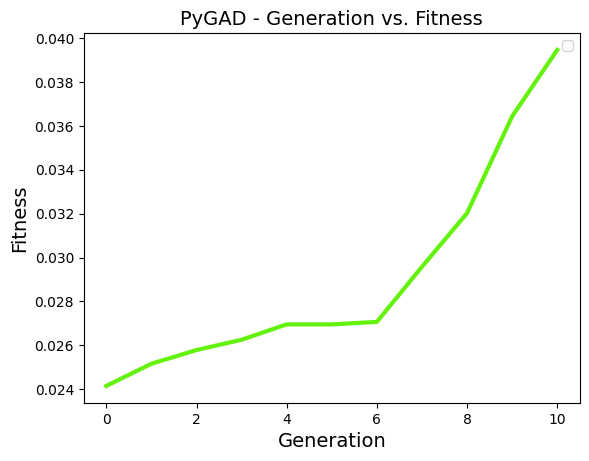

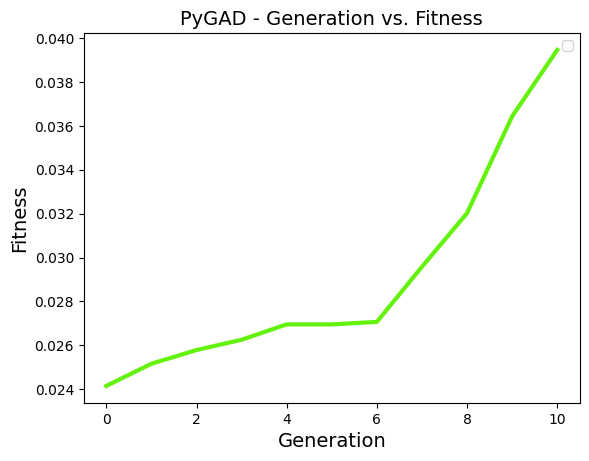

In [25]:
import pygad
import numpy

equation_inputs = [4,-2,3.5]
desired_output = 44

def fitness_func(ga_instance, solution, solution_idx):
    output = numpy.sum(solution * equation_inputs)
    fitness = 1.0 / (numpy.abs(output - desired_output) + 0.000001)
    return fitness

ga_instance = pygad.GA(num_generations=10,
                       sol_per_pop=5,
                       num_parents_mating=2,
                       num_genes=len(equation_inputs),
                       fitness_func=fitness_func)

ga_instance.run()
ga_instance.plot_fitness()

num_generations = 50
num_parents_mating = 2

fitness_function = fitness_func

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 2

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10